# DPA conversion to standard trace format.

In [16]:
import bz2
import math
import zipfile
import numpy as np
import tempfile
from tqdm import tqdm

from settings.dpa import DPA4

In [10]:
TMP_DIR = tempfile.mkdtemp()

for fname in tqdm(list(DPA4.TRACE_URLS.keys())):
    with zipfile.ZipFile(f"{DPA4.ROOT_RAW}/{fname}","r") as zip_ref:
        zip_ref.extractall(TMP_DIR)

TMP_DIR


  0%|          | 0/16 [00:21<?, ?it/s][A

100%|██████████| 5/5 [02:28<00:00, 29.64s/it]


'/tmp/tmp_gumwdzq'

In [13]:
with bz2.open(f"{TMP_DIR}/DPA_contestv4_2/k00/DPACV42_000000.trc.bz2", 'rb') as file:
    EXAMPLE_TRACE = bytearray(file.read())

TRACE_SIZE = 1704402
HEADER_SIZE = 357
len(EXAMPLE_TRACE) - TRACE_SIZE


358

### Header offsets

Acquired from [the DPA contest website](http://www.dpacontest.org/v4/42_traces.php) on 2020-11-26.

In [ ]:
HEADER_FIELDS = {
    0: ("Descriptor Name", str),
    16: ("Template Name", str),
    32: ("Comm Type", int),
    34: ("Comm Order", int),
    36: ("Wave Descriptor", int),
    40: ("User Text", int),
    44: ("Res Desc1", int),
    48: ("TrigTime Array", int),
    52: ("Ris Time Array", int),
    56: ("Res Array 1", int),
    60: ("Wave Array 1", int),
    64: ("Wave Array 2", int),
    76: ("Instrument Name", str),
    116: ("Wave Array Count", int),
    (116 + 4): ("END", None),
    124: ("First Valid Point", int),
    128: ("Last Valid Point", int),
    (128 + 4): ("END", None),
    156: ("Vertical gain", float),
    160: ("Vertical offset", float),
    172: ("Nominal Bits", int),
    (172 + 2): ("END", None),
}

In [21]:
START = 11

In [22]:
def parse_header(trace, start=START):
    offset = 0
    for next_offset in list(HEADER_FIELDS.keys())[1:]:
        f_name, f_type = HEADER_FIELDS[offset]
        header_part = trace[ offset+start:next_offset+start ]

        if f_type == str:
            print(f_name, ":\t", header_part.decode('ascii').rstrip('\x00'))
        elif f_type == int:
            print(f_name, ":\t", int.from_bytes(header_part, "little", signed=True))

        offset = next_offset

parse_header(EXAMPLE_TRACE)

NameError: name 'HEADER_FIELDS' is not defined

In [19]:
SPLIT = 5000
def get_filename(ix):
    return f"{TMP_DIR}/DPA_contestv4_2/k{str(math.floor(ix / SPLIT)).zfill(2)}/DPACV42_{str(ix).zfill(6)}.trc.bz2"

def get_trace_from_bz2(ix):
    with bz2.open(get_filename(ix), 'rb') as file:
        res = bytearray(file.read())

    return res

'/tmp/tmp_gumwdzq/DPA_contestv4_2/k00/DPACV42_004999.trc.bz2'

In [23]:
def get_trace(trace, start=START):
    # Check that the trace has the expected start offset.
    assert trace[start:start + 16].decode('ascii').rstrip('\x00') == "WAVEDESC"

    p_first = int.from_bytes(trace[124+start:128+start], "little", signed=True)
    p_last = int.from_bytes(trace[128+start:132+start], "little", signed=True)

    # Check that the trace has expected size.
    assert p_last - p_first == TRACE_SIZE - 1
    # Check that the trace ends with expected junk bytes.
    assert trace[-2:] == b'\xee\xee'

    return trace[-(p_last + 2):-2]

np.array([int(b) for b in get_trace(EXAMPLE_TRACE)])

array([  6,   8,   6, ..., 250, 246, 243])

<AxesSubplot:>

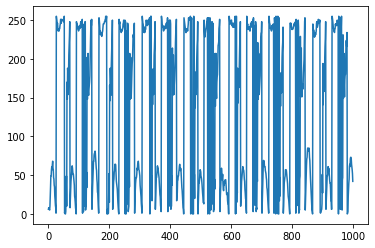

In [29]:
import seaborn as sns

sns.lineplot(data=np.array([int(b) for b in get_trace(EXAMPLE_TRACE)])[:1000])